<a href="https://colab.research.google.com/github/sisatput/IBM-Data-Classification/blob/main/Capstone_with_EDA_%26_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Colab (install & auth Replicate)

In [1]:
# --- INSTALL ---
!pip -q install kaggle replicate datasets transformers evaluate rouge-score
!pip -q install pandas matplotlib scikit-learn replicate

# --- KAGGLE AUTH (upload kaggle.json Anda) ---
from google.colab import files
import os, shutil

uploaded = files.upload()  # pilih kaggle.json Anda
if "kaggle.json" not in uploaded:
    raise FileNotFoundError("File 'kaggle.json' tidak ditemukan. Pastikan Anda memilihnya saat upload.")

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# --- REPLICATE AUTH (gunakan Colab Secrets) ---
# Di Colab: klik ikon 🔑 (Secrets), lalu tambahkan key: REPLICATE_API_TOKEN
try:
    from google.colab import userdata
    REPLICATE_API_TOKEN = userdata.get("REPLICATE_API_TOKEN")
    if not REPLICATE_API_TOKEN:
        raise ValueError("Secret 'REPLICATE_API_TOKEN' belum di-set. Tambahkan via Colab Secrets.")
    os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN
except Exception as e:
    raise RuntimeError("Gagal mengambil secret 'REPLICATE_API_TOKEN' dari Colab Secrets.") from e


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json


Ambil dataset AG News dari Kaggle

In [2]:
!kaggle datasets download -d amananandrai/ag-news-classification-dataset -q
!unzip -o ag-news-classification-dataset.zip -d agnews > /dev/null

import pandas as pd
train_df = pd.read_csv("agnews/train.csv")
test_df  = pd.read_csv("agnews/test.csv")

# Gabung title + description
for df in (train_df, test_df):
    df["text"] = df["Title"].astype(str) + ". " + df["Description"].astype(str)

label_map = {1:"World", 2:"Sports", 3:"Business", 4:"Sci/Tech"}


Dataset URL: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
License(s): unknown


Fungsi helper: panggil Granite di Replicate

In [3]:
import replicate, textwrap, time

GRANITE_MODEL = "ibm-granite/granite-3.3-8b-instruct"  # model slug di Replicate

SYSTEM_PROMPT = (
    "You are an analytical assistant. Respond in plain JSON only."
)

def granite_json(prompt, max_tokens=256, temperature=0.2):
    full_prompt = f"<|system|>\n{SYSTEM_PROMPT}\n<|user|>\n{prompt}\n<|assistant|>"
    out = replicate.run(
        f"{GRANITE_MODEL}",
        input={
            "prompt": full_prompt,
            "max_tokens": max_tokens,
            "temperature": temperature,
        },
    )
    # Replicate stream returns an iterator of chunks; join menjadi string
    text = "".join(list(out)).strip()
    return text


Zero-/Few-shot Classification dengan Granite

In [4]:
import json, numpy as np
from tqdm.auto import tqdm

CLASS_LABELS = ["World","Sports","Business","Sci/Tech"]

FEW_SHOTS = [
    {"text":"Fed hikes rates amid inflation concerns.", "label":"Business"},
    {"text":"Mars rover sends new images from crater.", "label":"Sci/Tech"},
    {"text":"Local team clinches championship title.", "label":"Sports"},
    {"text":"UN holds summit on global refugee crisis.", "label":"World"},
]

def build_classification_prompt(text):
    examples = "\n".join(
        [f'{{"text":"{e["text"]}","label":"{e["label"]}"}}' for e in FEW_SHOTS]
    )
    instr = f"""
Task: Classify the NEWS text into one of labels: {CLASS_LABELS}.
Return JSON with keys: label, confidence (0-1), rationale (short string).

Few-shot examples (JSON lines):
{examples}

Now classify this text:
{text}
Return only JSON.
"""
    return instr.strip()

# Contoh batch kecil untuk validasi cepat
sample_val = test_df.sample(50, random_state=42).copy()
preds = []
for t in tqdm(sample_val["text"].tolist()):
    js = granite_json(build_classification_prompt(t), max_tokens=180)
    # Robust parse
    try:
        j = json.loads(js)
        label = j.get("label","")
    except:
        label = ""
    preds.append(label)

sample_val["pred_label"] = preds
sample_val["true_label"] = sample_val["Class Index"].map(label_map)
acc = (sample_val["pred_label"] == sample_val["true_label"]).mean()
acc


  0%|          | 0/50 [00:00<?, ?it/s]

np.float64(0.88)

Summarization dengan Granite

In [5]:
def build_summarize_prompt(text, target_words=50):
    return f"""
Summarize the following news article in about {target_words} words.
Use concise Indonesian language if possible. Return JSON with keys: summary.

Article:
{text}
"""

# Coba 3 contoh ringkasan
demo = test_df.sample(3, random_state=7)["text"].tolist()
summaries = []
for t in demo:
    js = granite_json(build_summarize_prompt(t, target_words=60), max_tokens=220)
    try:
        j = json.loads(js); summaries.append(j["summary"])
    except:
        summaries.append(js)

for s in summaries:
    print("-"*80); print(s)


--------------------------------------------------------------------------------
Motorola berusaha memperkuat desain produk mereka. Pada ruangan kantor di tingkat 26 dengan pandangan langit Selat Michigan, sekitar 40 desainer industri, jeneng mekanik, dan ahli dari bidang-bidang bervariasi seperti antropologi dan musikologi bekerja sama untuk menciptakan produk yang lebih inovatif dan menggunakan teknologi terbaru.
--------------------------------------------------------------------------------
Rally di Wall Street diharapkan terus terjalin hingga Desember, tetapi terdapat berbagai berita buruk terkini yang mungkin menyebabkan perkembangan beli terhenti.
--------------------------------------------------------------------------------
Poland akan mengurangi sederet ke tiga dari pasukan milinya di Iraq pada tahun berikutnya. Menteri Pertahanan Poland, Jerzy Szmajdzinski, mengumumkan rencana tersebut.


Baseline Classifier (untuk pembanding di laporan)

In [6]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate, numpy as np

base_df = train_df[["text","Class Index"]].rename(columns={"Class Index":"label"}).copy()
base_df["label"] = base_df["label"] - 1  # 0..3

train_small = base_df.sample(20000, random_state=7)  # cepat saja
val_small   = test_df[["text","Class Index"]].rename(columns={"Class Index":"label"}).copy()
val_small["label"] = val_small["label"] - 1

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tok_fn(ex):
    return tok(ex["text"], truncation=True, padding="max_length", max_length=256)

train_ds = Dataset.from_pandas(train_small).map(tok_fn, batched=True)
val_ds   = Dataset.from_pandas(val_small).map(tok_fn, batched=True)

# keep only features yang dibutuhkan Trainer
keep_cols = ["input_ids", "attention_mask", "label"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep_cols]).with_format("torch")
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in keep_cols]).with_format("torch")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

metric = evaluate.load("accuracy")
def comp(eval_pred):
    logits, labels = eval_pred
    return metric.compute(predictions=np.argmax(logits,axis=-1), references=labels)

# NOTE: di Transformers v5, gunakan 'eval_strategy' (bukan 'evaluation_strategy')
# dan tambahkan 'logging_strategy' bila ingin pakai logging_steps
args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=100,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=comp,
)

trainer.train()
trainer.evaluate()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.254200,0.249176,0.921316


{'eval_loss': 0.24917574226856232,
 'eval_accuracy': 0.9213157894736842,
 'eval_runtime': 51.1888,
 'eval_samples_per_second': 148.47,
 'eval_steps_per_second': 4.649,
 'epoch': 1.0}

Simpan hasil (untuk repo & slide)

In [7]:
# Simpan ringkasan & prediksi Granite untuk contoh presentasi
export = sample_val[["text","true_label","pred_label"]].copy()
export.to_csv("granite_demo_preds.csv", index=False)

# (opsional) hitung ROUGE ringkasan bila punya reference
from rouge_score import rouge_scorer
# scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
# ... hitung skor jika tersedia reference summary


# 🔍 EDA & Model Evaluation Add-on

## 1) Class Distribution

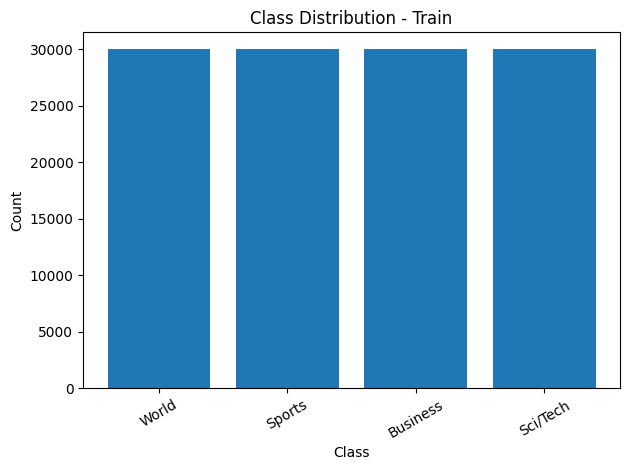

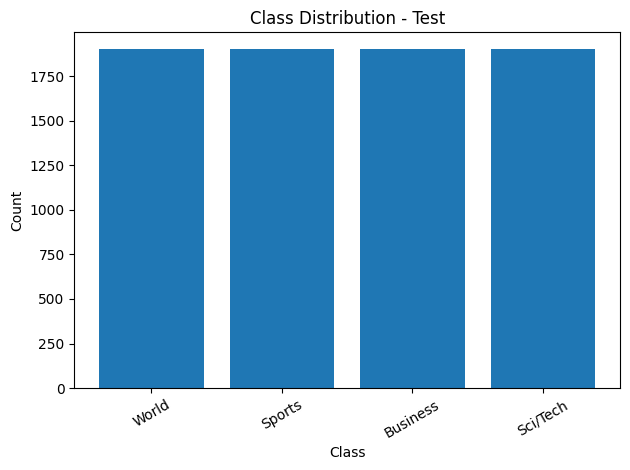

In [8]:
import matplotlib.pyplot as plt
def _map_label_idx_to_name(idx):
    if 'label_map' in globals():
        return label_map.get(idx, str(idx))
    return str(idx)
def plot_class_distribution(df, label_col="Class Index", title="Class Distribution"):
    counts = df[label_col].value_counts().sort_index()
    labels = [ _map_label_idx_to_name(i) for i in counts.index ]
    plt.figure()
    plt.bar(labels, counts.values)
    plt.title(title)
    plt.xlabel("Class"); plt.ylabel("Count"); plt.xticks(rotation=30); plt.tight_layout(); plt.show()

if 'train_df' in globals(): plot_class_distribution(train_df, "Class Index", "Class Distribution - Train")
if 'test_df' in globals():  plot_class_distribution(test_df,  "Class Index", "Class Distribution - Test")

## 2) Text Length per Class (Boxplot)

/tmp/ipython-input-3624404317.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(data, labels=labels, showfliers=False)


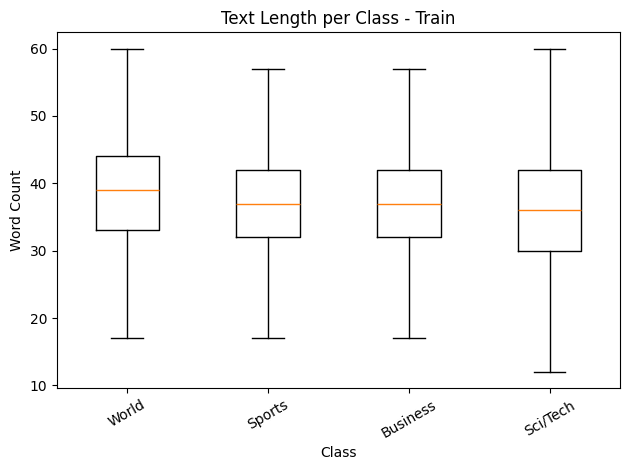

/tmp/ipython-input-3624404317.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(data, labels=labels, showfliers=False)


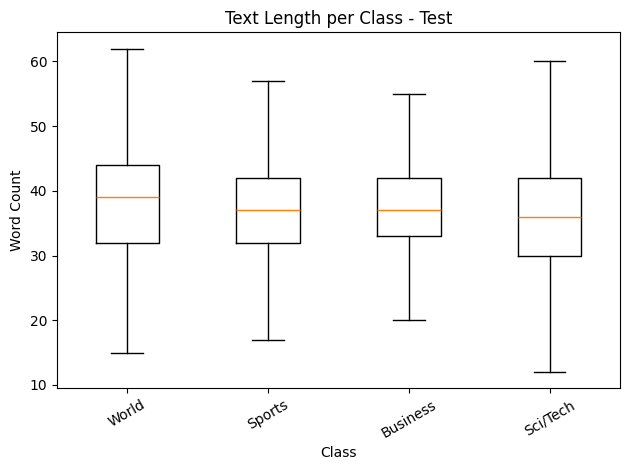

In [9]:
import numpy as np, matplotlib.pyplot as plt
def plot_text_length_boxplot(df, label_col="Class Index", text_col="text", title="Text Length per Class"):
    tmp = df[[label_col, text_col]].copy()
    tmp["_len"] = tmp[text_col].astype(str).str.split().map(len)
    classes = sorted(tmp[label_col].unique())
    data = [ tmp.loc[tmp[label_col]==c, "_len"].values for c in classes ]
    labels = [ _map_label_idx_to_name(c) for c in classes ]
    plt.figure(); plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title); plt.xlabel("Class"); plt.ylabel("Word Count"); plt.xticks(rotation=30); plt.tight_layout(); plt.show()

if 'train_df' in globals(): plot_text_length_boxplot(train_df, "Class Index", "text", "Text Length per Class - Train")
if 'test_df' in globals():  plot_text_length_boxplot(test_df,  "Class Index", "text", "Text Length per Class - Test")

## 3) Top Terms per Class (TF-IDF)

In [10]:
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_top_terms_per_class(df, text_col="text", label_col="Class Index", n_top=12, max_features=20000):
    vec = TfidfVectorizer(max_features=max_features, ngram_range=(1,2), stop_words="english")
    X = vec.fit_transform(df[text_col].astype(str).tolist()); terms = np.array(vec.get_feature_names_out())
    top_dict = {}
    for cls_idx in sorted(df[label_col].unique()):
        mask = (df[label_col]==cls_idx).values
        if mask.sum()==0: continue
        mean_scores = X[mask].mean(axis=0).A1
        top_idx = mean_scores.argsort()[::-1][:n_top]
        top_dict[_map_label_idx_to_name(cls_idx)] = list(zip(terms[top_idx], mean_scores[top_idx]))
    rows = []
    for cls, pairs in top_dict.items():
        for term, score in pairs:
            rows.append({"class": cls, "term": term, "avg_tfidf": float(score)})
    top_df = pd.DataFrame(rows).sort_values(["class","avg_tfidf"], ascending=[True, False])
    top_df.to_csv("tfidf_top_terms_per_class.csv", index=False)
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user("TF-IDF Top Terms per Class (Train)", top_df)
    except Exception: print(top_df.head(48))
if 'train_df' in globals(): tfidf_top_terms_per_class(train_df)

       class       term  avg_tfidf
24  Business         39   0.023203
25  Business        oil   0.022360
26  Business    reuters   0.020093
27  Business       said   0.016287
28  Business        new   0.015345
29  Business     prices   0.015342
30  Business     stocks   0.014406
31  Business    company   0.013783
32  Business         gt   0.012879
33  Business         lt   0.012807
34  Business    percent   0.011844
35  Business     profit   0.011150
36  Sci/Tech  microsoft   0.020165
37  Sci/Tech         39   0.018485
38  Sci/Tech        new   0.017600
39  Sci/Tech   software   0.014350
40  Sci/Tech   internet   0.013300
41  Sci/Tech         ap   0.011572
42  Sci/Tech      space   0.011443
43  Sci/Tech         gt   0.011139
44  Sci/Tech         lt   0.011118
45  Sci/Tech    company   0.009639
46  Sci/Tech       quot   0.009341
47  Sci/Tech      music   0.009333
12    Sports         39   0.031097
13    Sports         ap   0.019751
14    Sports       game   0.015707
15    Sports     sea

## 4) Confusion Matrix

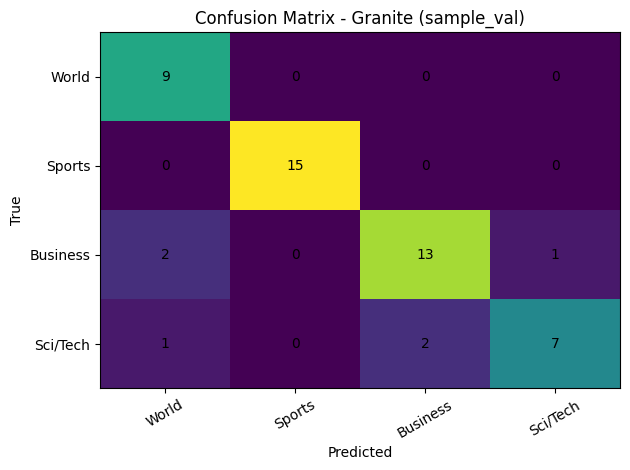

              precision    recall  f1-score   support

    Business      0.867     0.812     0.839        16
    Sci/Tech      0.875     0.700     0.778        10
      Sports      1.000     1.000     1.000        15
       World      0.750     1.000     0.857         9

    accuracy                          0.880        50
   macro avg      0.873     0.878     0.868        50
weighted avg      0.887     0.880     0.878        50



In [11]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(); plt.imshow(cm, interpolation="nearest", aspect="auto")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    ticks = np.arange(len(labels)); plt.xticks(ticks, labels, rotation=30); plt.yticks(ticks, labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout(); plt.show()

labels_order = ["World","Sports","Business","Sci/Tech"]
did=False
if 'sample_val' in globals() and all(c in sample_val.columns for c in ["true_label","pred_label"]):
    y_true = sample_val["true_label"].astype(str).tolist()
    y_pred = sample_val["pred_label"].astype(str).tolist()
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plot_confusion_matrix(cm, labels_order, "Confusion Matrix - Granite (sample_val)")
    print(classification_report(y_true, y_pred, digits=3))
    did=True

if not did and 'trainer' in globals() and 'val_ds' in globals():
    preds = trainer.predict(val_ds)
    idx_to_name = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}
    y_true = [idx_to_name[int(i)] for i in preds.label_ids]
    y_pred = [idx_to_name[int(i)] for i in preds.predictions.argmax(axis=1)]
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plot_confusion_matrix(cm, labels_order, "Confusion Matrix - Baseline")
    print(classification_report(y_true, y_pred, digits=3))
elif not did:
    print("Jalankan prediksi dulu agar CM dapat dibuat.")

## 5) Summarization Analysis

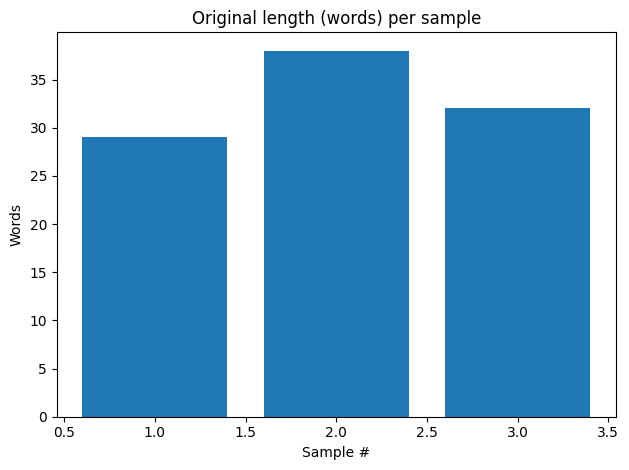

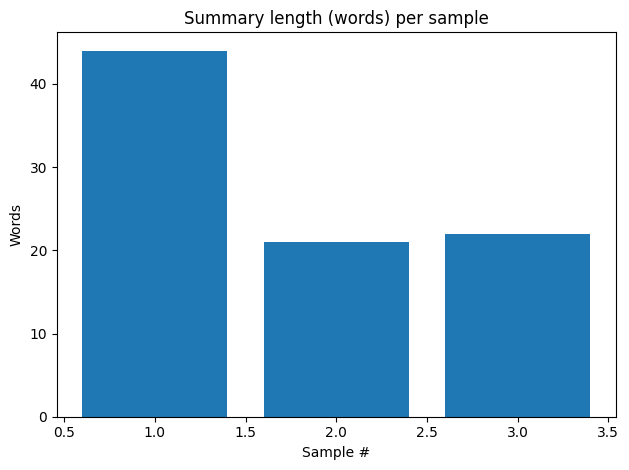

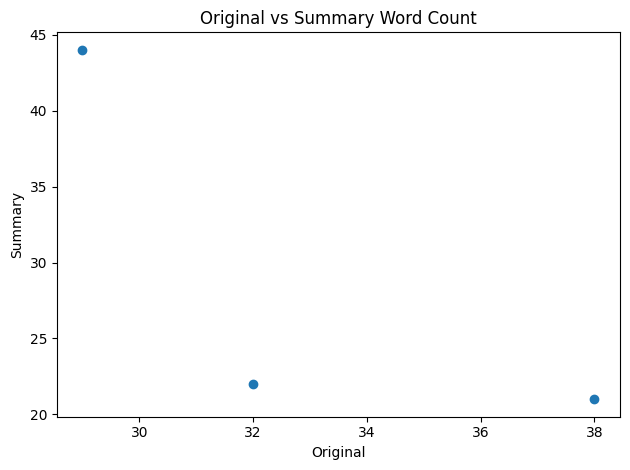

In [12]:
import matplotlib.pyplot as plt
def wc(s): return len(str(s).split())
if 'demo' in globals() and 'summaries' in globals() and len(demo)==len(summaries) and len(demo)>0:
    orig = [wc(x) for x in demo]; summ = [wc(x) for x in summaries]; xs = list(range(1, len(demo)+1))
    plt.figure(); plt.bar(xs, orig); plt.title("Original length (words) per sample"); plt.xlabel("Sample #"); plt.ylabel("Words"); plt.tight_layout(); plt.show()
    plt.figure(); plt.bar(xs, summ); plt.title("Summary length (words) per sample"); plt.xlabel("Sample #"); plt.ylabel("Words"); plt.tight_layout(); plt.show()
    plt.figure(); plt.scatter(orig, summ); plt.title("Original vs Summary Word Count"); plt.xlabel("Original"); plt.ylabel("Summary"); plt.tight_layout(); plt.show()
else:
    print("Variabel 'demo' & 'summaries' belum tersedia.")